In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
os.path.abspath(os.curdir)
os.chdir("..")
ML_FOLDER_PATH = os.path.abspath(os.curdir)
sys.path.append(ML_FOLDER_PATH)
import src.helpers as hlp


In [2]:
DATA_PATH='data/'

cols = ['Id','Prediction','DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

data = np.loadtxt(DATA_PATH + 'train.csv', delimiter = ',',
                        converters={1: lambda x: 0 if b'b' in x else 1},
                        skiprows=1)
data.shape

(250000, 32)

In [3]:
#looking at the NaNs per rows 
print(f'full dataset shape: \t\t{data.shape}\nremoving rows with nans :\
\t{data[~(data == -999.0).any(1),:].shape}')

full dataset shape: 		(250000, 32)
removing rows with nans :	(68114, 32)


bad idea to remove all rows containing -999.0 values. We would loose to much data

In [4]:
# ooking at the NaNs per column
na_cols_idx = np.where(data==-999.0)[1]
na_cols_idx = list(dict.fromkeys(na_cols_idx))
data_no_nans_cols=np.delete(data,na_cols_idx,axis=1)
cols_no_nans = [x for i,x in enumerate(cols) if i not in na_cols_idx]
print(f'full dataset shape: \t\t{data.shape}\nremoving columns with nans :\
\t{data_no_nans_cols.shape}')

full dataset shape: 		(250000, 32)
removing columns with nans :	(250000, 21)


11 columns would be lost if we decide to remove all columns containing -999.0 values.

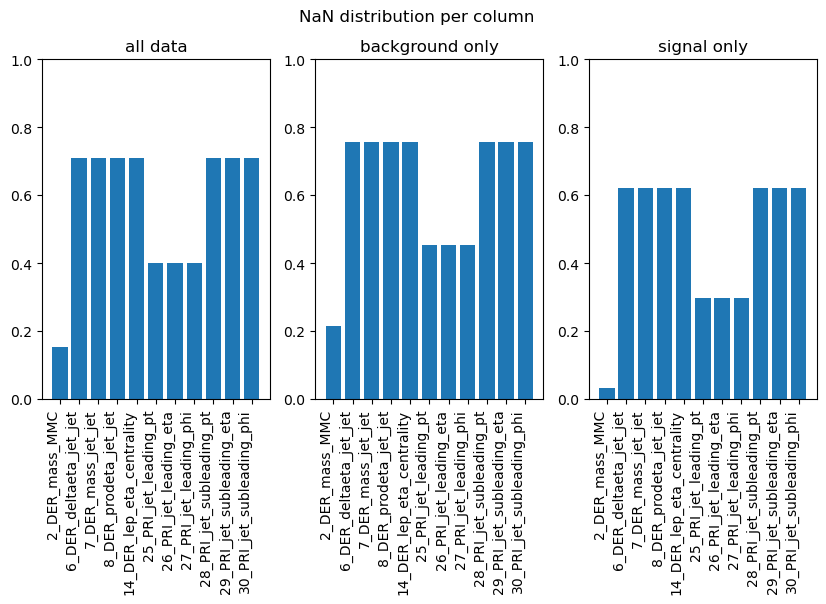

In [5]:
#analyzing nans per column distribution in total and per case
na_counts_total = {}
na_counts_1 = {}    #na counts for signal
na_counts_0 = {}    #na counts for background
for j in range(data.shape[1]):
    count = np.count_nonzero(data[:,j] == -999.0)
    count_1 = np.count_nonzero(data[data[:,1]==1,j]== -999.0)
    count_0 = np.count_nonzero(data[data[:,1]==0,j]== -999.0)
    if count !=0:
        na_counts_total[str(j)+'_'+cols[j]] = count/data.shape[0]
        na_counts_1[str(j)+'_'+cols[j]] = count_1/np.count_nonzero(data[:,1]==1)
        na_counts_0[str(j)+'_'+cols[j]] = count_0/np.count_nonzero(data[:,1]==0)

#plotting 
f,axs = plt.subplots(1,3, figsize=(10,5))
f.autofmt_xdate(rotation=90)
plt.setp(axs,ylim=(0,1))
plt.suptitle('NaN distribution per column')
axs[0].bar(na_counts_total.keys(),na_counts_total.values())
axs[1].bar(na_counts_0.keys(),na_counts_0.values())
axs[2].bar(na_counts_1.keys(),na_counts_1.values())
axs[0].set_title('all data')
axs[1].set_title('background only')
axs[2].set_title('signal only')
plt.show()



We then look at each columns without NaN distributions

In [6]:
def plot_all_distrs(data):
    f, axs = plt.subplots(4,5, figsize=(20,16))
    for i in range(19):
        axs[i//5,i%5].hist(data[:,i],bins=20)
        axs[i//5,i%5].title.set_text(cols_no_nans[i+2])
    plt.show()

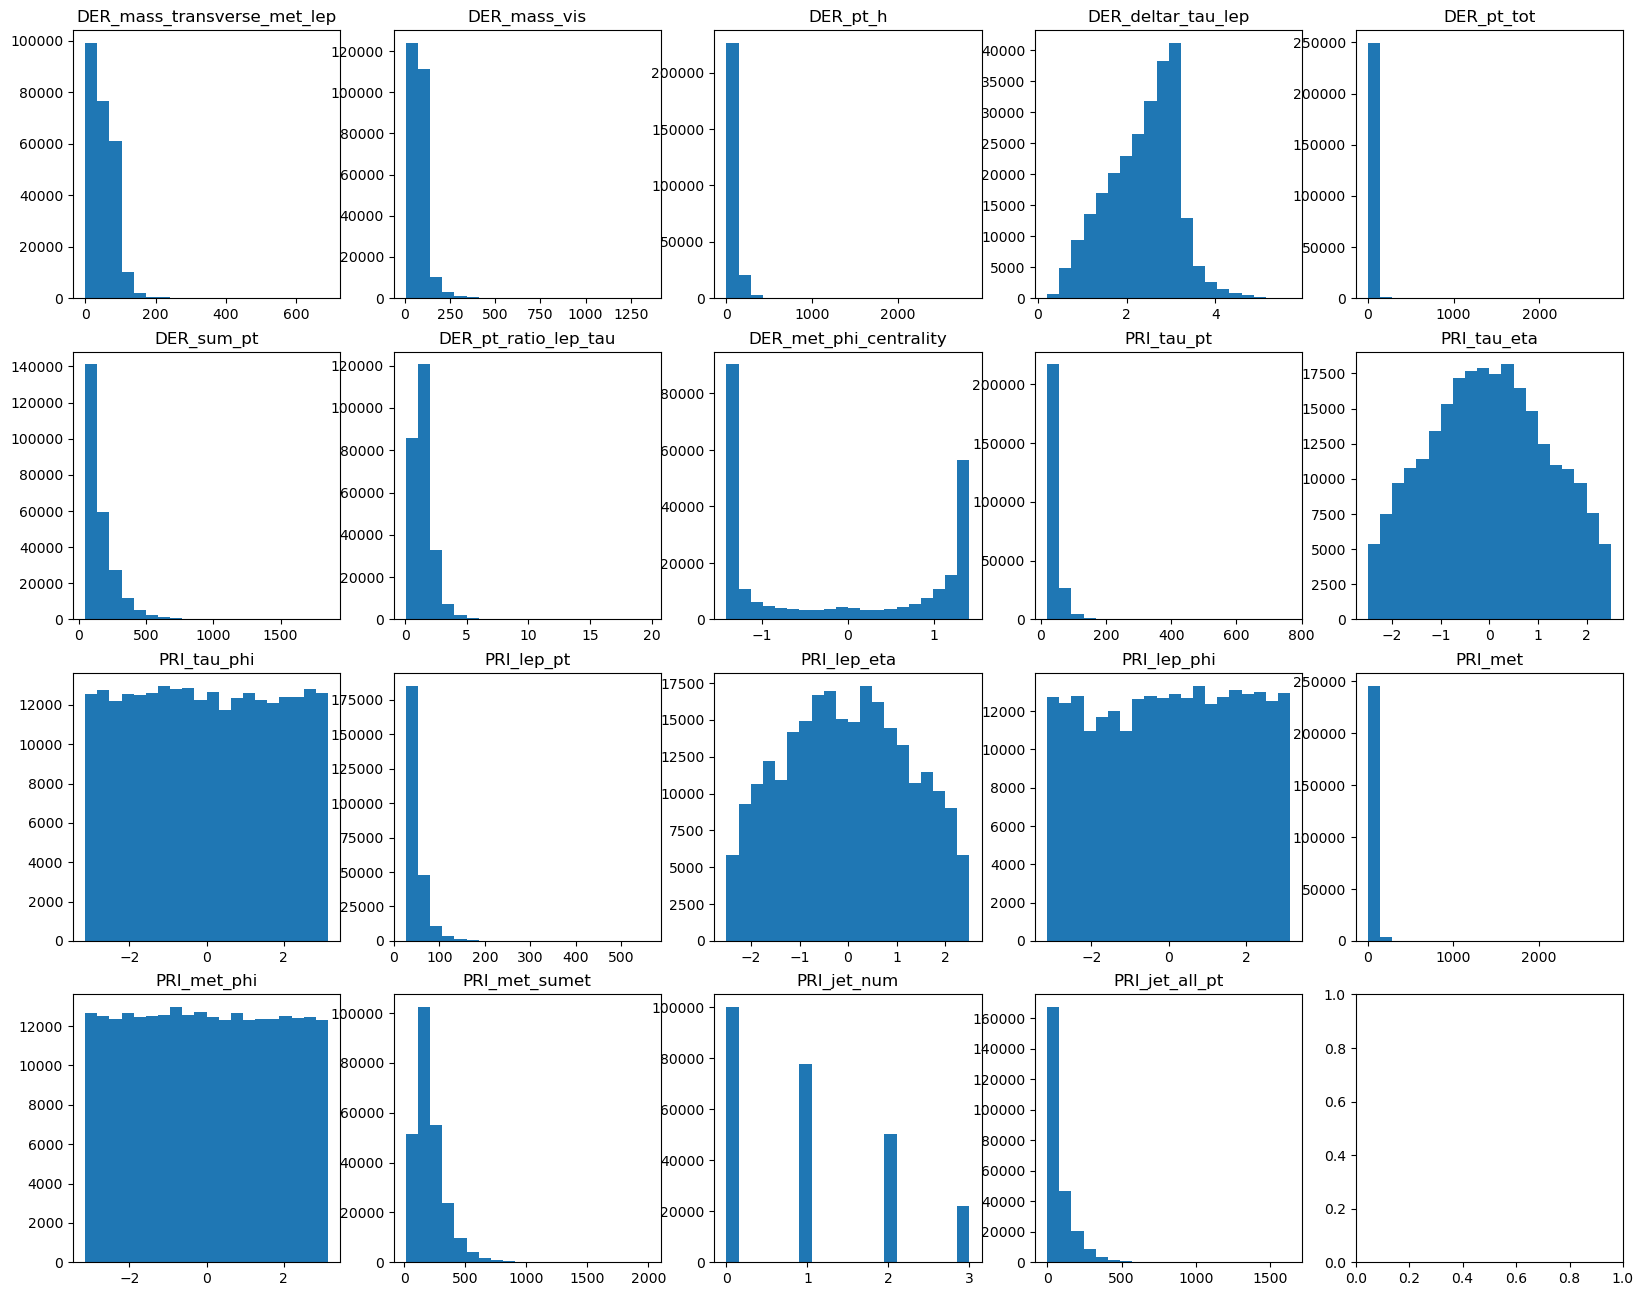

In [7]:
plot_all_distrs(data_no_nans_cols[:,2:])

Notice The very right distributions we decided to use $\textit{arcsinh}$ transformation to reduce the weights of outliers. We don't want to remove outliers because we want our model to be robust to them. Please refer to our report for more information.

In [8]:
#arcsinh transform
data_transformed = np.concatenate((data_no_nans_cols[:,:2],hlp.arcsinh_transform(data_no_nans_cols[:,2:])),axis=1)


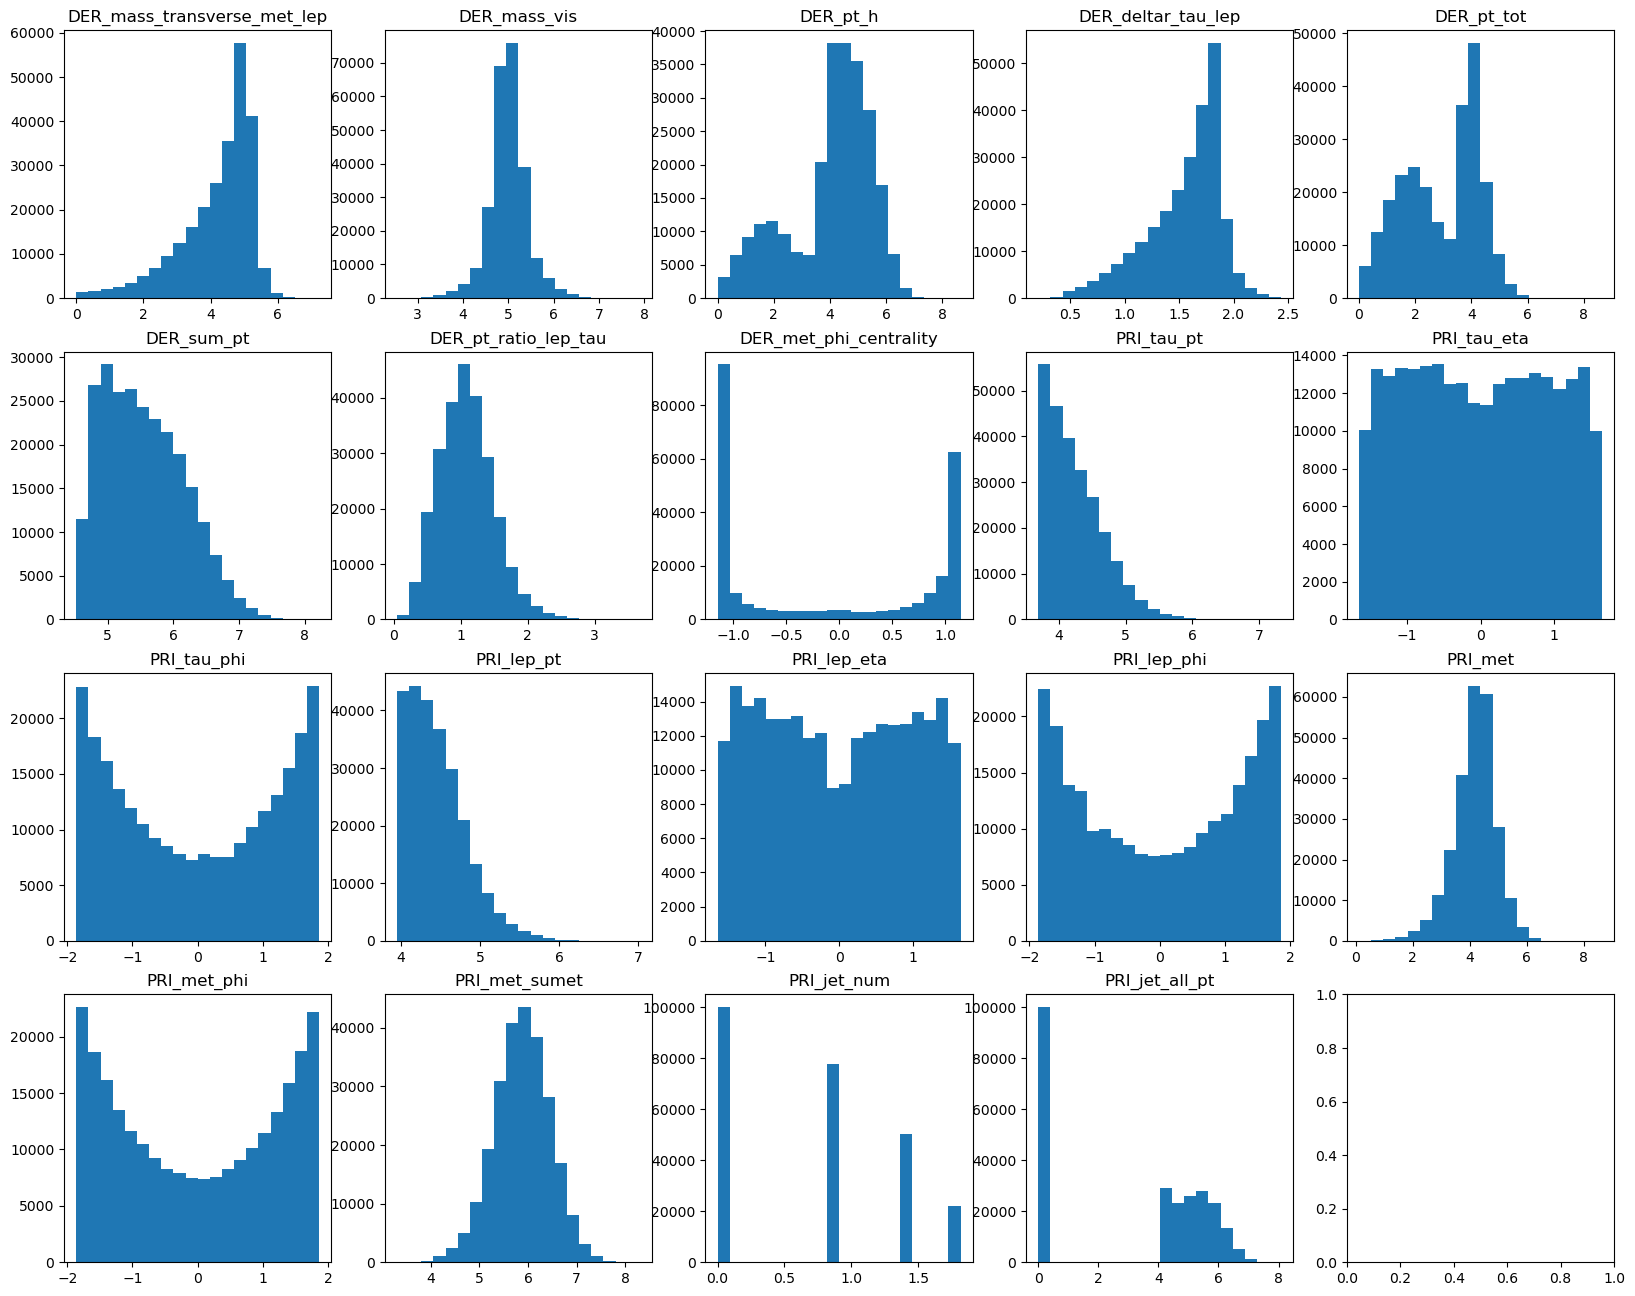

In [9]:
plot_all_distrs(data_transformed[:,2:])

Here the distributions look way better.

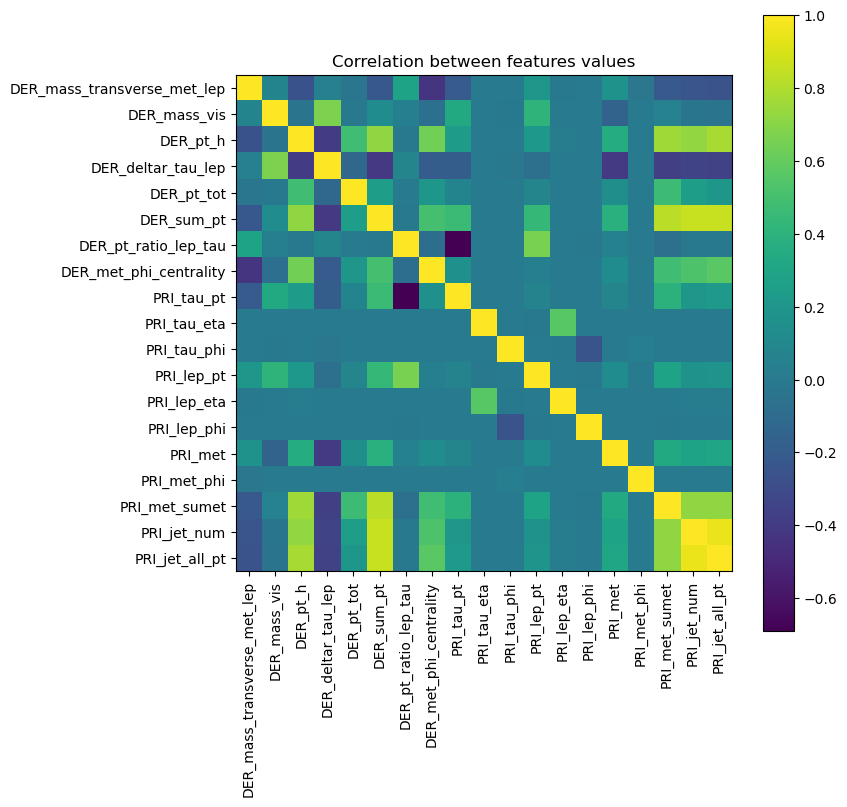

In [10]:
#corretion between every features
plt.figure(figsize=(8,8))
plt.title('Correlation between features values')
plt.imshow(np.corrcoef(data_transformed[:,2:].T))
plt.xticks(range(len(cols_no_nans)-2),cols_no_nans[2:], rotation='vertical')
plt.yticks(range(len(cols_no_nans)-2),cols_no_nans[2:])
plt.colorbar()
plt.show()

We note a strange behavior in the features having something to do with $\textit{jet}$. Looking more in depth at the number of NaNs features for the categorical feature $\textit{PRI-jet-num}$, we realize that they are dependant

In [11]:
jet_idx=24
data[data == -999.0] = float("nan")
data_0 = np.delete(data[data[:, jet_idx] == 0, :], jet_idx, axis=1)

data_0 = data_0[:, ~np.isnan(data_0).all(axis=0)]
data_1 = np.delete(data[data[:, jet_idx] == 1, :], jet_idx, axis=1)
data_1 = data_1[:, ~np.isnan(data_1).all(axis=0)]
data_2 = np.delete(data[data[:, jet_idx] == 2, :], jet_idx, axis=1)
data_2 = data_2[:, ~np.isnan(data_2).all(axis=0)]
data_3 = np.delete(data[data[:, jet_idx] == 3, :], jet_idx, axis=1)
data_3 = data_3[:, ~np.isnan(data_3).all(axis=0)]
print(f'shapes of datasets without NaNs with the different categorical feature values: \n\
jet=0: \t {data_0.shape[1]-2}\njet=1: \t {data_1.shape[1]-2}\njet=2: \t {data_2.shape[1]-2}\n\
jet=3: \t {data_3.shape[1]-2}')
#the -2 for each shape is because we still have the Ids and labels

shapes of datasets without NaNs with the different categorical feature values: 
jet=0: 	 19
jet=1: 	 22
jet=2: 	 29
jet=3: 	 29


We therefore decide to split the dataset along the $\textit{PRI-jet-num}$ feature.